In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/meme-dataset/val_with_reason.csv
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/9273.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/9292.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/4353.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/6262.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/2664.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/9110.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/1231.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/1017.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/7530.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/85

In [3]:
# Import necessary libraries
import os
import pandas as pd
import re
import string
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import AutoImageProcessor, SwinModel, DistilBertTokenizer, DistilBertModel
from torch.optim import AdamW
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, mean_squared_error
from tqdm import tqdm
import time

2025-07-11 20:08:46.826228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752264527.002254      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752264527.052620      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Set base paths
base_text_dir = '/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Text_dataset/'
base_image_dir = '/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/'
output_dir = '/kaggle/working/'

In [5]:
# Paths for text and image datasets
train_csv = os.path.join(base_text_dir, 'A_train.csv')
val_csv = os.path.join(base_text_dir, 'A_val.csv')
test_csv = os.path.join(base_text_dir, 'A_test.csv')
train_img_dir = os.path.join(base_image_dir, 'A_train_img')
val_img_dir = os.path.join(base_image_dir, 'A_val_img')
test_img_dir = os.path.join(base_image_dir, 'A_test_img')

In [6]:
import re
import pandas as pd
from functools import wraps

# NaN-safe decorator
def skip_if_nan(func):
    @wraps(func)
    def wrapper(text):
        if pd.isna(text):
            return text
        return func(text)
    return wrapper

# Precompiled patterns
url_pattern = re.compile(r'https?://\S+|www\.\S+')
html_pattern = re.compile(r'<.*?>')
emoji_pattern = re.compile(
    "[" 
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map
    u"\U0001F1E0-\U0001F1FF"  # flags
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)

@skip_if_nan
def to_lowercase(text):
    return text.lower()

@skip_if_nan
def remove_urls(text):
    return url_pattern.sub('', text)

@skip_if_nan
def remove_html(text):
    return html_pattern.sub('', text)

@skip_if_nan
def remove_emojis(text):
    return emoji_pattern.sub('', text)

@skip_if_nan
def remove_extra_whitespace(text):
    return " ".join(text.split())

@skip_if_nan
def clean_text(text):
    text = remove_urls(text)
    text = remove_html(text)
    text = remove_emojis(text)
    text = to_lowercase(text)  # only if using an uncased model
    text = remove_extra_whitespace(text)
    return text


In [7]:
# Function to map image paths, using index as filename (e.g., "1002.png")
def get_image_path(index, img_dir, is_train=False):
    if is_train:
        # Training set: check Hate and No Hate subfolders
        subfolders = ['Hate', 'No Hate', 'hate', 'no_hate', 'No_Hate']
        for subfolder in subfolders:
            img_path = os.path.join(img_dir, subfolder, index)
            if os.path.exists(img_path):
                print(f"Found image: {img_path}")
                return img_path
        print(f"No image found for index {index} in {img_dir}")
        return None
    else:
        # Validation and test sets: check directly in the folder
        img_path = os.path.join(img_dir, index)
        if os.path.exists(img_path):
            print(f"Found image: {img_path}")
            return img_path
        print(f"No image found for index {index} in {img_dir}")
        return None

# Load text data
print("Loading CSV files...")
try:
    train_df = pd.read_csv(train_csv)
    val_df = pd.read_csv(val_csv)
    test_df = pd.read_csv(test_csv)
except Exception as e:
    print(f"Error loading CSV files: {e}")
    raise

print("Train CSV head:")
print(train_df.head())
print("Validation CSV head:")
print(val_df.head())
print("Test CSV head:")
print(test_df.head())

# Verify index column
if 'index' not in train_df.columns or 'index' not in val_df.columns or 'index' not in test_df.columns:
    print("Error: 'index' column missing in one or more CSV files")
    raise ValueError("Missing 'index' column")

# Clean text column
print("Cleaning text data...")
train_df['text'] = train_df['text'].astype(str).apply(clean_text)
val_df['text'] = val_df['text'].astype(str).apply(clean_text)
test_df['text'] = test_df['text'].astype(str).apply(clean_text)

# Map labels (already 0 or 1)
train_df['label'] = train_df['label']
val_df['label'] = val_df['label']

# Add image paths
print("Mapping image paths...")
train_df['image_path'] = train_df['index'].apply(lambda x: get_image_path(x, train_img_dir, is_train=True))
val_df['image_path'] = val_df['index'].apply(lambda x: get_image_path(x, val_img_dir, is_train=False))
test_df['image_path'] = test_df['index'].apply(lambda x: get_image_path(x, test_img_dir, is_train=False))

# Log the number of matched images
print(f"Train: {train_df['image_path'].notna().sum()} images matched out of {len(train_df)}")
print(f"Validation: {val_df['image_path'].notna().sum()} images matched out of {len(val_df)}")
print(f"Test: {test_df['image_path'].notna().sum()} images matched out of {len(test_df)}")

# Filter out rows with missing images
train_df = train_df[train_df['image_path'].notna()]
val_df = val_df[val_df['image_path'].notna()]
test_df = test_df[test_df['image_path'].notna()]

# Check if DataFrames are empty
if train_df.empty:
    print("Error: Train DataFrame is empty after filtering")
if val_df.empty:
    print("Error: Validation DataFrame is empty after filtering")
if test_df.empty:
    print("Error: Test DataFrame is empty after filtering")

Loading CSV files...
Train CSV head:
      index                                               text  label
0  1001.png  transgirls who grow boobs but keep their cock ...      0
1  1005.png  realistic and wholesome representation of tran...      0
2  1008.png  united lgbt united sponsored you can color you...      0
3  1009.png  neolib politician i'm going to fuck my cat and...      1
4  1010.png  dad i'm gay i love you no matter what i also s...      1
Validation CSV head:
      index                                               text  label
0  1003.png  soon available on every women's bathroom say t...      0
1  1024.png  sides gay fries fries but they're g ya know 6 ...      0
2  1045.png  me doesn't want to talk about dating sex with ...      1
3  1046.png  ferb trans rights says aren't you a little you...      0
4  1080.png  bethesda tr ethesda tr modle east bethesda rus...      1
Test CSV head:
      index                                               text
0  1002.png  imagine onl

In [8]:
# Save preprocessed data
train_df.to_csv(os.path.join(output_dir, 'train_processed1.csv'), index=False)
val_df.to_csv(os.path.join(output_dir, 'val_processed1.csv'), index=False)
test_df.to_csv(os.path.join(output_dir, 'test_processed1.csv'), index=False)

print("Preprocessed data saved:")
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")

Preprocessed data saved:
Train shape: (3662, 4)
Validation shape: (506, 4)
Test shape: (507, 3)


In [9]:
import matplotlib.pyplot as plt
from PIL import Image
def show_sample(df, num_samples=5, title="Sample Data"):
    sample_df = df.sample(n=min(num_samples, len(df)))

    plt.figure(figsize=(15, 3 * num_samples))
    for i, (_, row) in enumerate(sample_df.iterrows()):
        try:
            img = Image.open(row['image_path']).convert("RGB")

            plt.subplot(num_samples, 1, i + 1)
            plt.imshow(img)
            plt.axis('off')

            label_text = f"Label: {row['label']} | " if 'label' in row else ""
            plt.title(f"{label_text}Text: {row['text']}", fontsize=12)

        except Exception as e:
            print(f"Failed to load image: {row['image_path']} — {e}")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



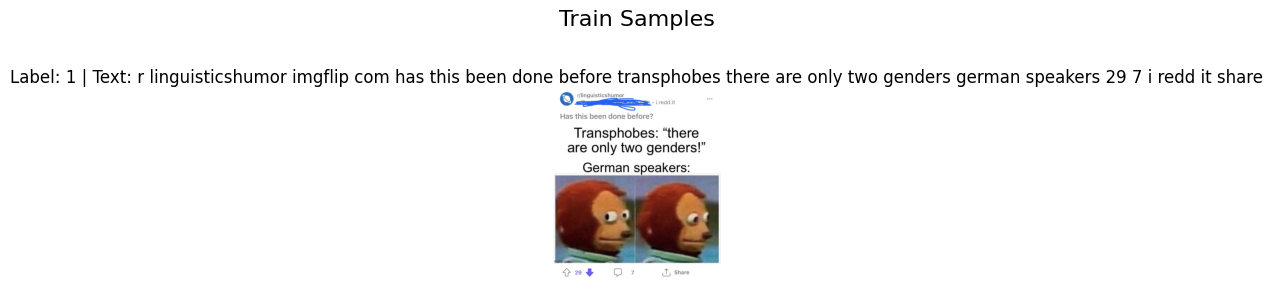

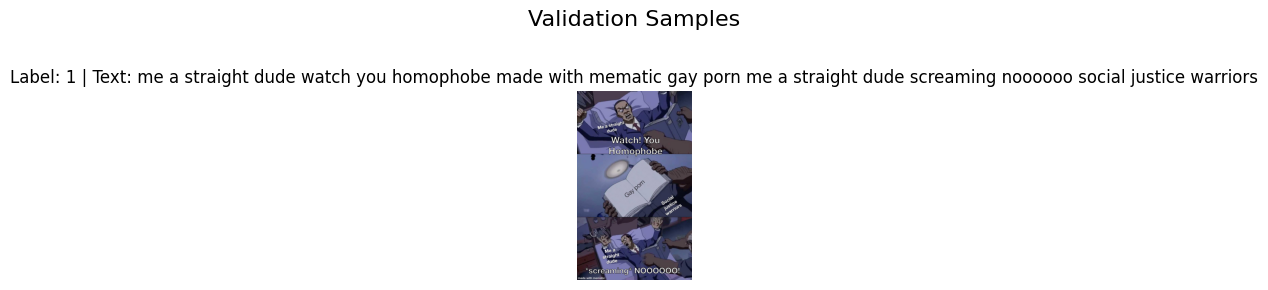

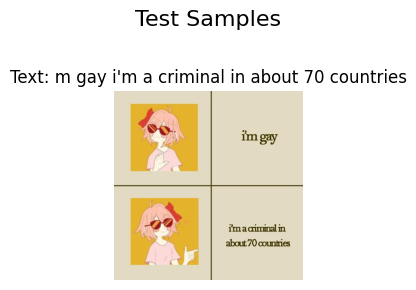

In [10]:
show_sample(train_df, num_samples=1, title="Train Samples")
show_sample(val_df, num_samples=1, title="Validation Samples")
show_sample(test_df, num_samples=1, title="Test Samples")


In [11]:
# Custom Dataset class for multimodal data
class MemeDataset(Dataset):
    def __init__(self, dataframe, image_processor, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.image_processor = image_processor
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        # Load and process image
        try:
            image = Image.open(row['image_path']).convert('RGB')
            image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {row['image_path']}: {e}")
            image = torch.zeros(3, 224, 224)  # Fallback empty image

        # Process text
        text = row['text']
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        item = {
            'image': image,
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'index': row['index']  # Include index
        }

        # Include label for train/val, exclude for test
        if 'label' in row:
            item['label'] = torch.tensor(row['label'], dtype=torch.float)

        return item

class MultimodalMemeClassifier(nn.Module):
    def __init__(self, swin_model_name="microsoft/swin-tiny-patch4-window7-224", 
                 distilbert_model_name="distilbert-base-uncased", hidden_dim=256):
        super(MultimodalMemeClassifier, self).__init__()
        # Image model (Swin Transformer)
        self.swin = SwinModel.from_pretrained(swin_model_name)
        
        # Text model (DistilBERT)
        self.distilbert = DistilBertModel.from_pretrained(distilbert_model_name)
        
        # Separate branches for late-fusion
        swin_output_dim = self.swin.config.hidden_size
        distilbert_output_dim = self.distilbert.config.hidden_size
        
        # Fully connected layers for each modality
        self.image_fc = nn.Linear(swin_output_dim, hidden_dim)
        self.text_fc = nn.Linear(distilbert_output_dim, hidden_dim)
        
        # Fusion and classification layers
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_dim * 2, 1)  # Combine features from both modalities
        self.sigmoid = nn.Sigmoid()

    def forward(self, images, input_ids, attention_mask):
        # Image features
        swin_outputs = self.swin(pixel_values=images)
        image_features = swin_outputs.pooler_output  # Use pooler_output (batch_size, hidden_size)
        if image_features is None:
            image_features = swin_outputs.last_hidden_state.mean(dim=1)  # Fallback to mean pooling
        
        # Process image features through separate FC layer
        image_features = F.relu(self.image_fc(image_features))
        
        # Text features
        text_outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # CLS token
        
        # Process text features through separate FC layer
        text_features = F.relu(self.text_fc(text_features))
        
        # Combine features (late-fusion)
        combined = torch.cat((image_features, text_features), dim=1)
        combined = self.dropout(combined)
        logits = self.classifier(combined)
        probs = self.sigmoid(logits)
        return probs
        
# Initialize processors and tokenizers
image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Create datasets
train_dataset = MemeDataset(train_df, image_processor, tokenizer)
val_dataset = MemeDataset(val_df, image_processor, tokenizer)
test_dataset = MemeDataset(test_df, image_processor, tokenizer)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Initialize model, optimizer, and loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalMemeClassifier().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCELoss()

# Training function
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    
    for batch in tqdm(data_loader, desc="Training"):
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = (outputs >= 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    return avg_loss, accuracy, precision, recall, f1

# Validation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(images, input_ids, attention_mask).squeeze()
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            preds = (outputs >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    return avg_loss, accuracy, precision, recall, f1

# Test prediction function
def predict_test(model, data_loader, device):
    model.eval()
    all_preds = []
    all_indices = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Predicting"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(images, input_ids, attention_mask).squeeze()
            preds = (outputs >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_indices.extend(batch['index'])
            
    return all_preds, all_indices

# Training loop
num_epochs = 15
best_val_f1 = 0
best_model_path = os.path.join(output_dir, 'best_model.pth')

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    # Train
    train_loss, train_acc, train_prec, train_rec, train_f1 = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
          f"Prec: {train_prec:.4f}, Rec: {train_rec:.4f}, F1: {train_f1:.4f}")
    
    # Validate
    val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(
        model, val_loader, criterion, device
    )
    print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, "
          f"Prec: {val_prec:.4f}, Rec: {val_rec:.4f}, F1: {val_f1:.4f}")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model with F1: {best_val_f1:.4f}")

# Load best model for testing
model.load_state_dict(torch.load(best_model_path))
print("Loaded best model for testing")

# Generate test predictions
test_preds, test_indices = predict_test(model, test_loader, device)

# Save test predictions
test_results = pd.DataFrame({
    'index': test_indices,
    'prediction': test_preds
})
test_results.to_csv(os.path.join(output_dir, 'test_predictions.csv'), index=False)
print(f"Test predictions saved to {os.path.join(output_dir, 'test_predictions.csv')}")

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


Epoch 1/15


Training: 100%|██████████| 229/229 [01:37<00:00,  2.34it/s]


Train Loss: 0.6336, Acc: 0.6458, Prec: 0.6209, Rec: 0.6449, F1: 0.6327


Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]


Val Loss: 0.5596, Acc: 0.7332, Prec: 0.8087, Rec: 0.5968, F1: 0.6868
Saved best model with F1: 0.6868

Epoch 2/15


Training: 100%|██████████| 229/229 [01:24<00:00,  2.70it/s]


Train Loss: 0.4847, Acc: 0.7703, Prec: 0.7538, Rec: 0.7639, F1: 0.7588


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Val Loss: 0.5135, Acc: 0.7549, Prec: 0.7650, Rec: 0.7218, F1: 0.7427
Saved best model with F1: 0.7427

Epoch 3/15


Training: 100%|██████████| 229/229 [01:25<00:00,  2.68it/s]


Train Loss: 0.2906, Acc: 0.8859, Prec: 0.8746, Rec: 0.8857, F1: 0.8801


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Val Loss: 0.5701, Acc: 0.7569, Prec: 0.7193, Rec: 0.8266, F1: 0.7692
Saved best model with F1: 0.7692

Epoch 4/15


Training: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s]


Train Loss: 0.1323, Acc: 0.9569, Prec: 0.9544, Rec: 0.9544, F1: 0.9544


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Val Loss: 0.7239, Acc: 0.7332, Prec: 0.7678, Rec: 0.6532, F1: 0.7059

Epoch 5/15


Training: 100%|██████████| 229/229 [01:22<00:00,  2.79it/s]


Train Loss: 0.0807, Acc: 0.9749, Prec: 0.9751, Rec: 0.9717, F1: 0.9734


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Val Loss: 0.8188, Acc: 0.7391, Prec: 0.7788, Rec: 0.6532, F1: 0.7105

Epoch 6/15


Training: 100%|██████████| 229/229 [01:25<00:00,  2.69it/s]


Train Loss: 0.0407, Acc: 0.9891, Prec: 0.9902, Rec: 0.9867, F1: 0.9884


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Val Loss: 0.9892, Acc: 0.7332, Prec: 0.7783, Rec: 0.6371, F1: 0.7007

Epoch 7/15


Training: 100%|██████████| 229/229 [01:24<00:00,  2.70it/s]


Train Loss: 0.0343, Acc: 0.9907, Prec: 0.9913, Rec: 0.9890, F1: 0.9902


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Val Loss: 1.0259, Acc: 0.7431, Prec: 0.7757, Rec: 0.6694, F1: 0.7186

Epoch 8/15


Training: 100%|██████████| 229/229 [01:25<00:00,  2.67it/s]


Train Loss: 0.0368, Acc: 0.9896, Prec: 0.9879, Rec: 0.9902, F1: 0.9890


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Val Loss: 1.2354, Acc: 0.7036, Prec: 0.7952, Rec: 0.5323, F1: 0.6377

Epoch 9/15


Training: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s]


Train Loss: 0.0223, Acc: 0.9937, Prec: 0.9931, Rec: 0.9936, F1: 0.9934


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.85it/s]


Val Loss: 1.1212, Acc: 0.7372, Prec: 0.7949, Rec: 0.6250, F1: 0.6998

Epoch 10/15


Training: 100%|██████████| 229/229 [01:24<00:00,  2.70it/s]


Train Loss: 0.0090, Acc: 0.9984, Prec: 0.9977, Rec: 0.9988, F1: 0.9983


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


Val Loss: 1.2599, Acc: 0.7332, Prec: 0.7868, Rec: 0.6250, F1: 0.6966

Epoch 11/15


Training: 100%|██████████| 229/229 [01:24<00:00,  2.70it/s]


Train Loss: 0.0187, Acc: 0.9940, Prec: 0.9942, Rec: 0.9931, F1: 0.9936


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Val Loss: 1.1743, Acc: 0.7233, Prec: 0.7547, Rec: 0.6452, F1: 0.6957

Epoch 12/15


Training: 100%|██████████| 229/229 [01:25<00:00,  2.68it/s]


Train Loss: 0.0150, Acc: 0.9959, Prec: 0.9965, Rec: 0.9948, F1: 0.9957


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Val Loss: 1.1764, Acc: 0.7372, Prec: 0.7106, Rec: 0.7823, F1: 0.7447

Epoch 13/15


Training: 100%|██████████| 229/229 [01:25<00:00,  2.68it/s]


Train Loss: 0.0232, Acc: 0.9943, Prec: 0.9942, Rec: 0.9936, F1: 0.9939


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


Val Loss: 1.0499, Acc: 0.7451, Prec: 0.7280, Rec: 0.7661, F1: 0.7466

Epoch 14/15


Training: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s]


Train Loss: 0.0129, Acc: 0.9967, Prec: 0.9965, Rec: 0.9965, F1: 0.9965


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


Val Loss: 1.1839, Acc: 0.7352, Prec: 0.7591, Rec: 0.6734, F1: 0.7137

Epoch 15/15


Training: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s]


Train Loss: 0.0190, Acc: 0.9934, Prec: 0.9925, Rec: 0.9936, F1: 0.9931


Evaluating: 100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Val Loss: 1.1615, Acc: 0.7391, Prec: 0.7417, Rec: 0.7177, F1: 0.7295
Loaded best model for testing


Predicting: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]

Test predictions saved to /kaggle/working/test_predictions.csv
